<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Package Imports
</p>

In [1]:
# General imports
import re
import numpy as np
import pandas as pd
from warnings import filterwarnings
from tqdm.notebook import tqdm
from gc import collect
from IPython.display import clear_output, display, HTML
from termcolor import colored

# Configure pandas display options
pd.options.display.max_rows = 50
pd.set_option('display.float_format', '{:,.5f}'.format)

# Data processing and statistical analysis
from scipy.stats import mode, iqr, anderson, shapiro, normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Visualization libraries and settings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Set warnings filter (to ignore warnings)
filterwarnings('ignore')


In [2]:
# Model imports:-

from sklearn import datasets
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, RobustScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 22px; text-align: left; padding: 10px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Project description
</p>

<div style="color: #333333; 
           display: block; 
           border-radius: 12px;
           background-color: #FAFBFD; 
           font-size: 14px; 
           font-family: 'Roboto', sans-serif; 
           letter-spacing: 0.5px;
           padding: 20px; 
           border: 1px solid #CCCCCC; 
           ">
    
The data is generated by a deep learning model trained on the Machine Failure Predictions dataset. The relationships between the variables are akin to those in the original dataset but with notable distinctions.

We're delving into two distinct datasets: the **Training dataset**, which houses both predictor variables and the target variable; and the **Testing dataset**, carrying only the predictor variables.

The target variable, or our focus for prediction, is **Machine Failure** — a binary indicator revealing whether a machine has failed. The predictor variables at our disposal include:

- **`Product ID`**: Acts as a specific identifier for products or machines, potentially revealing if certain machines are more prone to failure.
- **`Type`**: The category of machine, which could influence its likelihood of failure.
- **`Air temperature [K]`** and **`Process temperature [K]`**: Critical in forecasting machine failure, as overheating is a common failure cause.
- **`Rotational speed [rpm]`**: The operation speed, with higher speeds possibly leading to increased failure risks.
- **`Torque [Nm]`**: The operational force, where excessive torque can signify wear and tear, leading to failure.
- **`Tool wear [min]`**: The usage duration of tools, where longer use periods might forecast imminent failure.

Additionally, we assess specific types of failures, each marked by a binary indicator:
- **`TWF`** (Tool Wear Failure),
- **`HDF`** (Heat Dissipation Failure),
- **`PWF`** (Power Failure),
- **`OSF`** (Overstrain Failure),
- **`RNF`** (Random Failure).

Should any of these failure indicators be triggered, it signals the machine's functional demise.

**Evaluating Our Model's Performance**

We're evaluating the model's effectiveness primarily based on the area under the ROC curve, which compares predicted probabilities to actual outcomes.

**Analysis Phases**

**Phase 1: Data Examination**

Our initial analysis stage encompasses a thorough dataset review—identifying and rectifying missing values, evaluating feature distribution, spotting outliers, and conducting normality tests to ensure data quality and reliability.

**Phase 2: Data Correction**

This stage aims at addressing and amending early-detected anomalies, crucial for enhancing the dataset's overall quality and setting a solid foundation for predictive modeling.

**Phase 3: Predictive Modeling**

Concluding our analysis, we embark on developing and deploying a **binary classification model**, aspiring to accurately predict machine failures and measure our success against the precision of the area under the ROC curve.

</div>

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Assigning global variables
</p>

In [3]:
# Assigning global variables to be used throughout:-
target = 'Machine failure'

binary_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',  'Tool wear [min]']

grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--',
              'color': 'lightgrey', 'linewidth': 0.50}

title_specs = {'fontsize': 14, 'fontweight': 'bold', 'color': 'tab:blue'}

def PrintColor(text:str, color:str = 'blue', attrs:list = ['bold', 'dark']):
    """
    Prints color outputs using termcolor-colored using a text F-string
    """
    print(colored(text, color = color, attrs = attrs))

<p style="font-family: 'Roboto', sans-serif; font-weight: bold; letter-spacing: normal; color: #005792; font-size: 16px; text-align: left; padding: 5px; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">
  Importing Train and Test Dataset
</p>

In [4]:
%%time

# Importing the data:-
xytrain = pd.read_csv('../data/train.csv', encoding = 'utf8')
xtest = pd.read_csv('../data/test.csv', encoding = 'utf8')

# Displaying the datasets:-
PrintColor(f"\nTrain data\n")
display(xytrain.head(5))

PrintColor(f"\nTest data\n")
display(xtest.head(5))

PrintColor(f"\nExtracting features from Test data\n")

features = xtest.columns
display(features)

print();


Train data



,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.60000,309.60000,1596,36.10000,140,0,0,0,0,0,0
1,1,M20343,M,302.60000,312.10000,1759,29.10000,200,0,0,0,0,0,0
2,2,L49454,L,299.30000,308.50000,1805,26.50000,25,0,0,0,0,0,0
3,3,L53355,L,301.00000,310.90000,1524,44.30000,197,0,0,0,0,0,0
4,4,M24050,M,298.00000,309.00000,1641,35.40000,34,0,0,0,0,0,0



Test data



,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.30000,311.50000,1499,38.00000,60,0,0,0,0,0
1,136430,L53866,L,301.70000,311.00000,1713,28.80000,17,0,0,0,0,0
2,136431,L50498,L,301.30000,310.40000,1525,37.70000,96,0,0,0,0,0
3,136432,M21232,M,300.10000,309.60000,1479,47.60000,5,0,0,0,0,0
4,136433,M19751,M,303.40000,312.30000,1515,41.30000,114,0,0,0,0,0



Extracting features from Test data



Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


CPU times: total: 141 ms
Wall time: 269 ms


<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  
Data Preprocessing
</p>


In [5]:
PrintColor(f"\nExtracting unique records per feature from Train and Test data\n")

PrintColor(f"\nTrain data unique records\n")
display(xytrain.nunique())

PrintColor(f"\nTest data unique records\n")
display(xtest.nunique())


Extracting unique records per feature from Train and Test data


Train data unique records



id                         136429
Product ID                   9976
Type                            3
Air temperature [K]            95
Process temperature [K]        81
Rotational speed [rpm]        952
Torque [Nm]                   611
Tool wear [min]               246
Machine failure                 2
TWF                             2
HDF                             2
PWF                             2
OSF                             2
RNF                             2
dtype: int64


Test data unique records



id                         90954
Product ID                  9909
Type                           3
Air temperature [K]           92
Process temperature [K]       84
Rotational speed [rpm]       946
Torque [Nm]                  595
Tool wear [min]              246
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  Dropping the "id" column from Train and Test data

</p>

In [6]:
xytrain = xytrain.drop(['id', 'Product ID'], axis=1)
xtest = xtest.drop(['id', 'Product ID'], axis=1)

In [7]:
PrintColor(f'Train Data set contains {xytrain.duplicated().sum()} duplicated rows')

PrintColor(f'\nTest Data set contains {xtest.duplicated().sum()} duplicated rows\n')

Train Data set contains 1156 duplicated rows

Test Data set contains 528 duplicated rows



<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  Dropping duplicated rows from Train and Test data

</p>

In [8]:
xytrain = xytrain.drop_duplicates()

xtest = xtest.drop_duplicates()

In [9]:
PrintColor(f"\nData information - Train and Test data")

PrintColor(f"\nTrain data information\n")
display(xytrain.info())

PrintColor(f"\nTest data information\n")
display(xtest.info())


Data information - Train and Test data

Train data information

<class 'pandas.core.frame.DataFrame'>
Index: 135273 entries, 0 to 136428
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     135273 non-null  object 
 1   Air temperature [K]      135273 non-null  float64
 2   Process temperature [K]  135273 non-null  float64
 3   Rotational speed [rpm]   135273 non-null  int64  
 4   Torque [Nm]              135273 non-null  float64
 5   Tool wear [min]          135273 non-null  int64  
 6   Machine failure          135273 non-null  int64  
 7   TWF                      135273 non-null  int64  
 8   HDF                      135273 non-null  int64  
 9   PWF                      135273 non-null  int64  
 10  OSF                      135273 non-null  int64  
 11  RNF                      135273 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 13.4+

None


Test data information

<class 'pandas.core.frame.DataFrame'>
Index: 90426 entries, 0 to 90953
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     90426 non-null  object 
 1   Air temperature [K]      90426 non-null  float64
 2   Process temperature [K]  90426 non-null  float64
 3   Rotational speed [rpm]   90426 non-null  int64  
 4   Torque [Nm]              90426 non-null  float64
 5   Tool wear [min]          90426 non-null  int64  
 6   TWF                      90426 non-null  int64  
 7   HDF                      90426 non-null  int64  
 8   PWF                      90426 non-null  int64  
 9   OSF                      90426 non-null  int64  
 10  RNF                      90426 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 8.3+ MB


None

<div style="color: #333; border-radius: 12px; background-color: #fafbfd; font-size: 14px; font-family: 'Arial', sans-serif; padding: 20px; border: 1px solid #ccc;">
    
The 'id' and 'Product ID' columns, serving as a generic identifiers, have been removed from both the Train and Test datasets. We identified and eliminated a total of 1,156 duplicate entries in the Train and 528 duplicates in the Test dataset. Additionally, both datasets are free from any null values.
</div>

<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  Creating a function to offer a comprehensive summary of the Training and Testing datasets.

</p>

In [10]:
def describe_dataframes(*dataframes, percentiles, target):
    """
    Generate and display descriptive statistics for given dataframes.

    Parameters:
    - dataframes: Tuples of DataFrame and its corresponding source name.
    - percentiles: List of percentiles to calculate.
    - target: The target variable to exclude from the description.
    """
    # Initialize an empty list to hold the modified dataframes
    described_dfs = [
        df.drop(target, axis=1, errors='ignore')
        .describe(percentiles=percentiles)
        .transpose()
        .drop('count', axis=1)
        .assign(source=source)
        .reset_index()
        .set_index(['index', 'source'])
        for df, source in dataframes
    ]
    # Concatenate and display the results
    all_described = pd.concat(described_dfs).sort_index(ascending=[True, False])
    display(all_described.style.format('{:.2f}'))

In [11]:
percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.95, 0.99]

PrintColor('\nData description - Train and Test data\n')

describe_dataframes((xytrain,'Train'),(xtest,'Test'), percentiles=percentiles, target=target)


Data description - Train and Test data



<div style="color: #333; border-radius: 12px; background-color: #fafbfd; font-size: 14px; font-family: 'Arial', sans-serif; padding: 20px; border: 1px solid #ccc;">
    
As the Test dataset from the Kaggle competition doesn't include a target column, I'll focus solely on analyzing the Training dataset going forward. Additionally, I'll utilize the Training dataset to create a predictive model, as the nested cross-validation process will be employed.
</div>

<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  
Creating a function to visualize the distribution of Numerical Features.
</p>

In [12]:
def features_box_kde_plot(features, data, target, grid_specs=grid_specs, title_specs=title_specs):
    """
    This function makes a boxplot and a KDE plot for the Train dataset for each feature.

    Parameters:
    - features: list of feature names to plot
    - data: DataFrame containing the training data
    - grid_specs: Dictionary containing grid specifications
    - title_specs: Dictionary containing title specifications
    """
    nrows = len(features)

    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3 * nrows))
    
    for i, feature in enumerate(features):
        sns.boxplot(data=data, x=target, y=feature,  ax=ax[i, 0])
        ax[i, 0].set_title(f'{feature}-Machine Failure', **title_specs)
        ax[i, 0].grid(**grid_specs)
        ax[i, 0].set(xlabel='', ylabel='')

        sns.kdeplot(data=data, x=feature, ax=ax[i, 1], fill=True)
        ax[i, 1].set_title(f'{feature}', **title_specs) 
        ax[i, 1].grid(**grid_specs)
        ax[i, 1].set(xlabel='', ylabel='')

    plt.tight_layout()

CPU times: total: 3.67 s
Wall time: 5.59 s


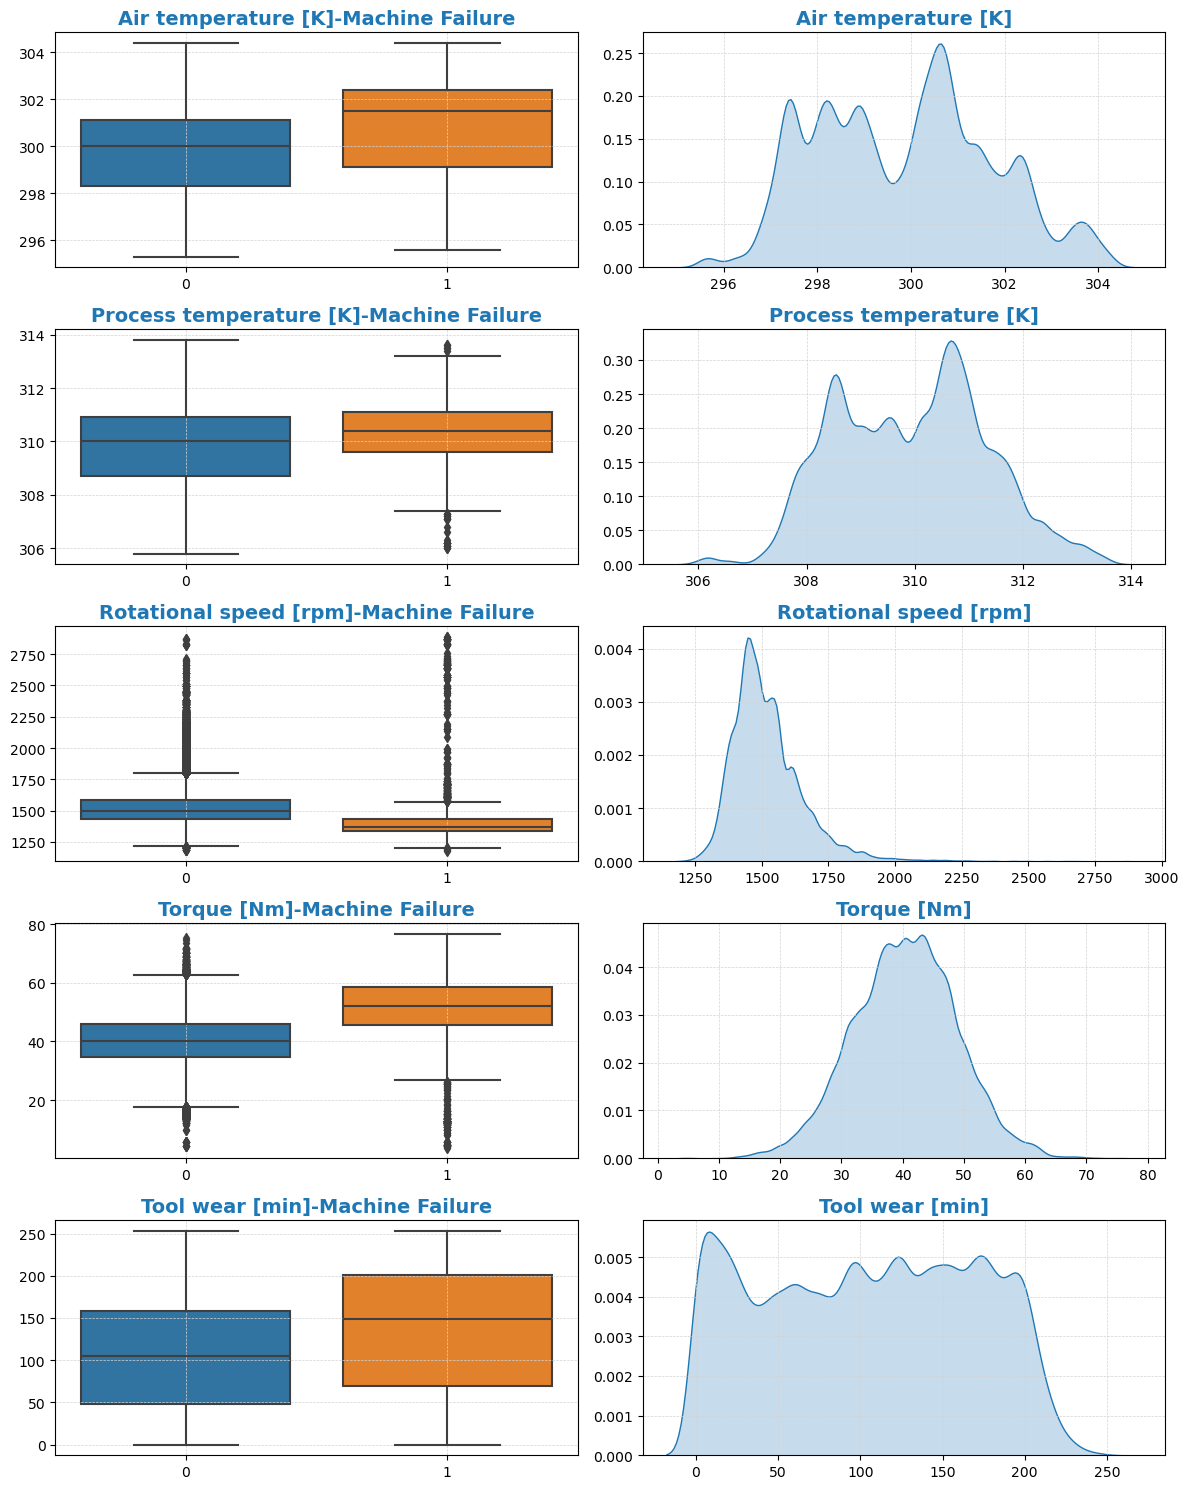

In [13]:
%%time

features_box_kde_plot(numerical_features, xytrain, target)

<div style="color: #333; border-radius: 12px; background-color: #fafbfd; font-size: 14px; font-family: 'Arial', sans-serif; padding: 20px; border: 1px solid #ccc;">
The median value and Interquartile Range (IQR) are generally higher for all variables except for rotational speed at machine failure. This suggests that machine failure tends to occur at higher values of temperature and torque. Additionally, the torque and rotational speed variables exhibit the highest number of outliers among the variables analyzed.
</div>

<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  Creating a function to check normality in numerical features

</p>

In [14]:
def normality_test(features, data, ad_signifance_level=0.5):
    """
    Performs normality tests on given features for training and test datasets,
    and returns a DataFrame with the test results and a normality flag.

    Parameters:
    - features: List of feature names.
    - xytrain: DataFrame containing the training data.
    - xtest: DataFrame containing the test data.
    """
    # preparing the Dataframe
    normal_test_results = pd.DataFrame(columns=['Feature', 'NormalTest', 'Shapiro'])

    # performing normality test
    for col in features:
        row = {
            'Feature' : col,
            'NormalTest' : normaltest(data[col])[1],
            'Shapiro' : shapiro(data[col])[1]
        }
        normal_test_results = pd.concat([normal_test_results, pd.DataFrame([row])], ignore_index=True)

    # determing normality
    normal_test_results['Is_Normal'] = np.where(
        (normal_test_results['NormalTest'] > ad_signifance_level) |
        (normal_test_results['Shapiro'] > ad_signifance_level), 'Y', 'N'
    )
    PrintColor('\nNormality test results for Numerical Features:\n')
    display(normal_test_results.style.format(precision=2).applymap(
        lambda x: 'background-color: #FFC0CB; color: #000000; font-weight:bold' if x == 'N' else 'background-color: #90EE90; color: #000000',
        subset=['Is_Normal'])
           )
    return normal_test_results

In [15]:
%%time

normality_test_results = normality_test(numerical_features, xytrain)


Normality test results for Numerical Features:



,Feature,NormalTest,Shapiro,Is_Normal
0,Air temperature [K],0.00,0.00,N
1,Process temperature [K],0.00,0.00,N
2,Rotational speed [rpm],0.00,0.00,N
3,Torque [Nm],0.00,0.00,N
4,Tool wear [min],0.00,0.00,N


CPU times: total: 62.5 ms
Wall time: 221 ms



<div style="color: #333; border-radius: 12px; background-color: #fafbfd; font-size: 14px; font-family: 'Arial', sans-serif; padding: 20px; border: 1px solid #ccc;">
It appears that none of the numerical features demonstrate a normal distribution. This issue will be addressed later through a logarithmic transformation when we approach the modeling phase.
</dtent))

<p style="font-family: Arial, sans-serif; font-weight: bold; color: #005792; font-size: 16px; text-align: left; border-bottom: 2px solid #007ACC; background-color: #F0F8FF;">  
Numerical Features vs Machine Type

</p>

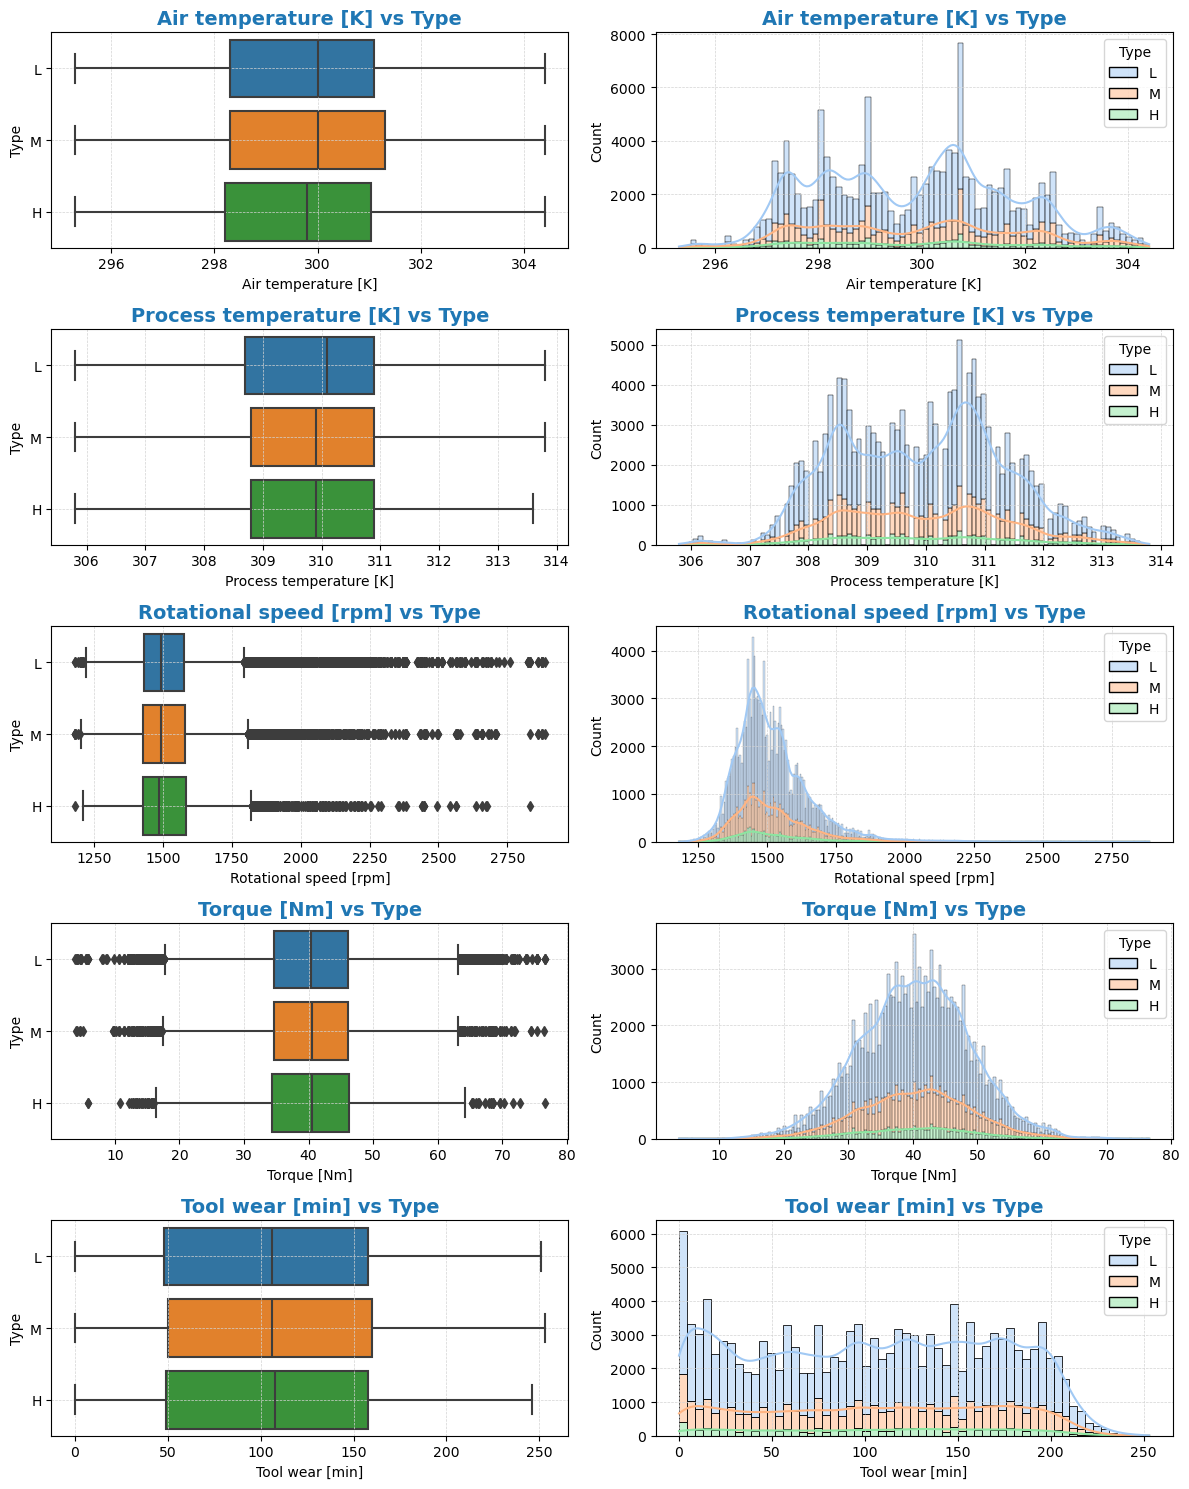

In [36]:
%%time

nrows = len(numerical_features)

fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3 * nrows))
    
for i, feature in enumerate(numerical_features):
    sns.boxplot(data=xytrain, x=feature, y='Type',  ax=ax[i, 0])
    ax[i, 0].set_title(f'{feature} vs Type', **title_specs)
    ax[i, 0].grid(**grid_specs)

    sns.histplot(data=xytrain, x=feature, hue='Type', ax=ax[i, 1], palette='pastel', kde=True, multiple='stack')
    ax[i, 1].set_title(f'{feature} vs Type', **title_specs)
    ax[i, 1].grid(**grid_specs)

    plt.tight_layout()